In [1]:
import scvelo as scv
import scanpy as spy
import numpy as np  
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import json
import anndata
import pandas as pd
import scprep


import multraj.visual as visual
import multraj.clustering as clust
import multraj.pp as pp
import multraj.path as path
import multraj.nn as nn
import multraj.princurve as pcurve
import multraj.benchmark as bmk


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.kernel_ridge import KernelRidge

## Meta-cell construction

In [2]:
# read in simulated dataset
# adata = anndata.read_h5ad("./sim_data/Symsim/multi_cycles_400_rand1_clust.h5ad")
adata = anndata.read_h5ad("./sim_data/Symsim/multi_cycles_200_rand5.h5ad")

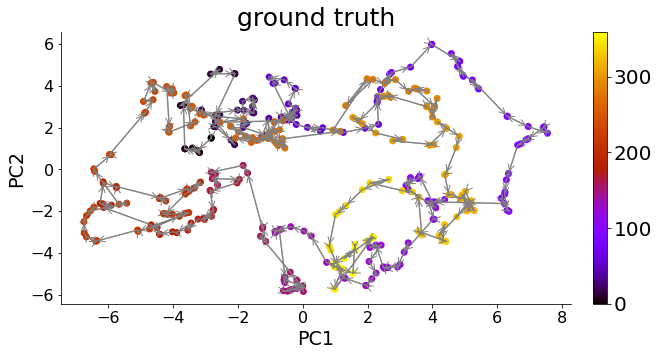

In [3]:
X_pca = adata.obsm['X_pca']
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()

# ax.plot(X_pca[:,0],X_pca[:,1], 'b-')
for i in range(X_pca.shape[0]-1):
    line = ax.plot(X_pca[i:(i+2), 0], X_pca[i:(i+2), 1], 'gray', alpha = 0.7)
    visual.add_arrow(line[0])
pic = ax.scatter(X_pca[:,0],X_pca[:,1], alpha = 1, cmap = 'gnuplot', c = np.arange(X_pca.shape[0]))

ax.tick_params(axis = "both", direction = "out", labelsize = 16)
ax.set_xlabel("PC1", fontsize = 19)
ax.set_ylabel("PC2", fontsize = 19)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("ground truth", fontsize = 25)

cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
cbar.ax.tick_params(labelsize = 20)
# fig.savefig("./sim_results/Symsim/multiple_cycles/400/ground_truth.pdf", bbox_inches = "tight")

In [4]:
# number of clusters
clusters = 100
# number of trials
n_trials = 10
# cluster obj

clust.cluster_cells(adata, n_clusters = clusters, n_init = n_trials)

X_cluster, velo_cluster = clust.meta_cells(adata)
# number of clusters
groups = adata.obs['groups']

# adata.write_h5ad("./sim_data/Symsim/multi_cycles.h5ad")

The clusters with radius close to 0 has components number:


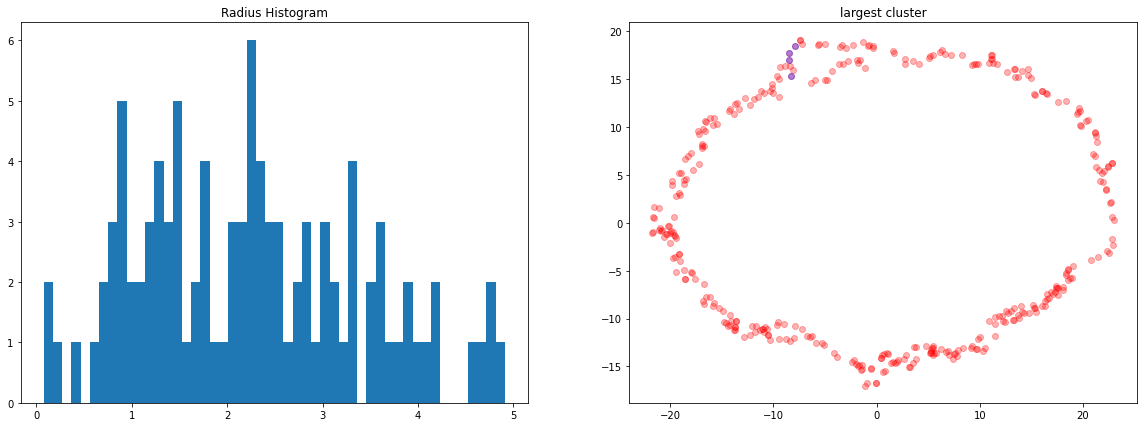

In [5]:
max_group = visual.radius_hist(adata, scaling=50)

## Neighborhood graph construction

make symmetric by adding


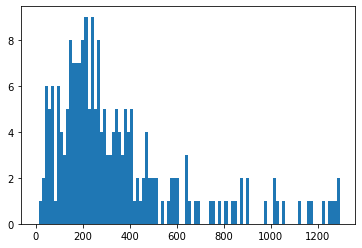

In [6]:
k = 5 #10
adj_matrix,dist_matrix = nn.NeighborhoodGraph(X_cluster,k, symm = True, pruning=False)
adj_assigned, max_weight = nn.assign_weights(adj_matrix,dist_matrix, X_cluster, velo_cluster,scaling = 4,\
                              distance_scaler = 0.5,thresholding = 0.0)
visual.weight_histogram(adj_assigned, scaling=100,upper=max_weight)

## Meta-cell level paths inference

In [7]:
paths, opt = path.dijkstra_paths(adj_assigned, indeg = [0,1,2])
clusters = int(np.max(groups)+1)
greedy_paths, paths = path.greedy_selection(clusters, paths, opt, threshold = 0.5, max_w=max_weight, cut_off=0, verbose=True, length_bias = 0.5, max_trajs = 15)

cut off small paths and conduct quality control
selected path (starting_ending):
start_end:  71_73 , len:  63 newly covered: 63
start_end:  8_17 , len:  57 newly covered: 8
start_end:  86_67 , len:  61 newly covered: 4
start_end:  21_73 , len:  60 newly covered: 1
Finished


In [8]:
trajs = 1

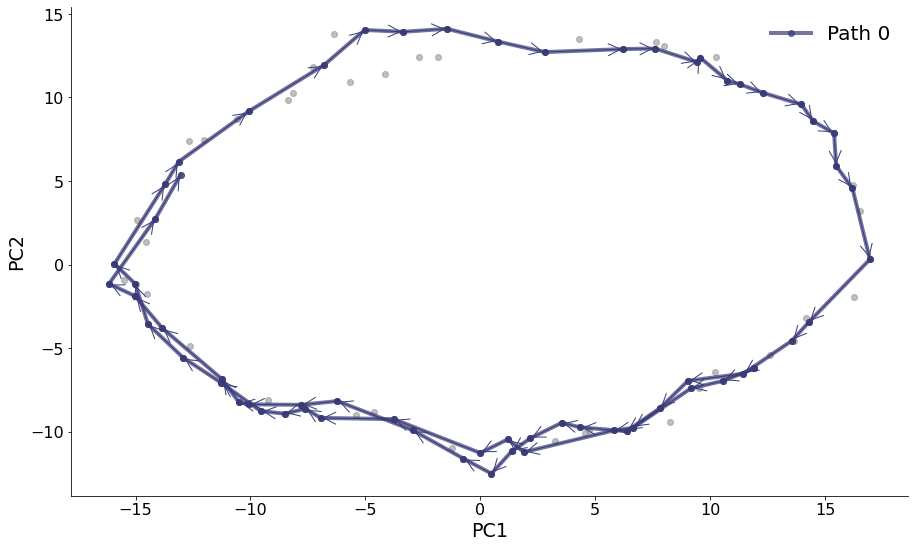

In [9]:
visual.meta_traj_visual(X_cluster, paths, greedy_paths, trajs = trajs, figsize = (15,9), save_as = None)#"./sim_results/Symsim/multiple_cycles/400/clust_paths.pdf")

## Cell-level pseudo-time inference

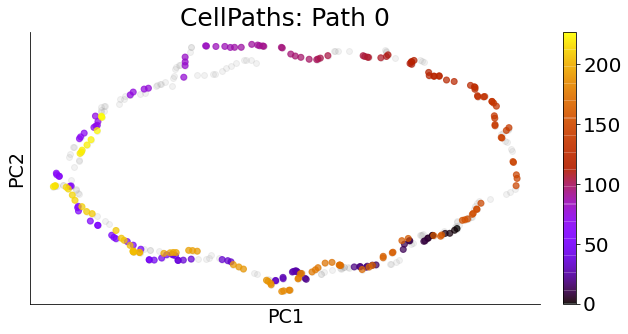

In [10]:
trajs = 1
pseudo_order = visual.first_order_approx_pt(adata, paths, greedy_paths, X_cluster, velo_cluster, basis = 'pca', groups = None, trajs = trajs, figsize= (10,5), save_as = None)#"./sim_results/Symsim/multiple_cycles/400/first_order_pt.pdf")

# Benchmark
## Kendall-tau test
### CellPaths

In [11]:
non_zeros = {}
pt_pred = {}
pt_true = {}
kt = {}
for icol, col in enumerate(pseudo_order.columns):
    non_zeros[col] = np.where(~np.isnan(pseudo_order[col].values.squeeze()))[0]
    pt_pred[col] = pseudo_order.iloc[non_zeros[col], icol].values.squeeze()
    pt_true[col] = adata.obs["sim_time"].iloc[non_zeros[col]].values
    kt[col] = bmk.kendalltau(pt_pred[col], pt_true[col])

In [12]:
kt

{&#39;traj_0&#39;: 0.9956719993817141}

In [13]:
X_pca = adata.obsm['X_pca']

n_clusters = 10
init = "k-means++"
n_init = 10
max_iter = 300
tol = 0.0001
kmeans = KMeans(n_clusters, init, n_init, max_iter, tol)
groups = kmeans.fit_predict(X_pca)
meta_data = adata.obs
meta_data['groups'] = groups

Text(0.5, 1.0, &#39;slingshot clusters&#39;)

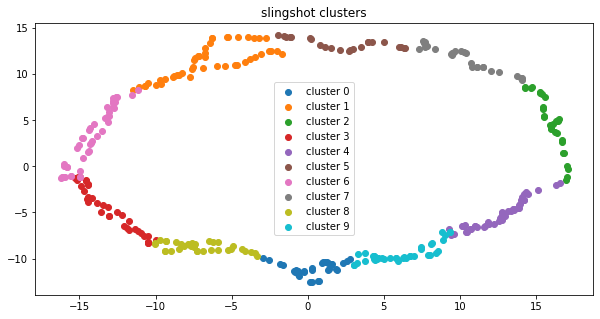

In [14]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()
c_range = [eval(x) if isinstance(x, str) else x for x in adata.obs['sim_time']]
clusters = int(np.max(groups)+1)
for i in range(clusters):
    sub_cells = np.where(groups == i)[0]
    progression = ax.scatter(X_pca[sub_cells,0], X_pca[sub_cells,1], cmap = plt.get_cmap('Pastel1'))
    # progression = ax.scatter(X_umap[sub_cells,0], X_umap[sub_cells,1], cmap = plt.get_cmap('Pastel1'))

ax.legend(['cluster '+ str(i) for i in range(clusters)])
ax.set_title("slingshot clusters")
# fig.savefig("./syn_results/dataset1/slingshot_clust.pdf")

In [15]:
X_pca_df = pd.DataFrame(index=[str(x) for x in range(X_pca.shape[0])], columns= np.arange(2), data = X_pca[:,0:2])
# scprep.run.install_bioconductor('slingshot')
results = scprep.run.Slingshot(X_pca_df, meta_data['groups'], start_cluster = 1)

R[write to console]: Using full covariance matrix


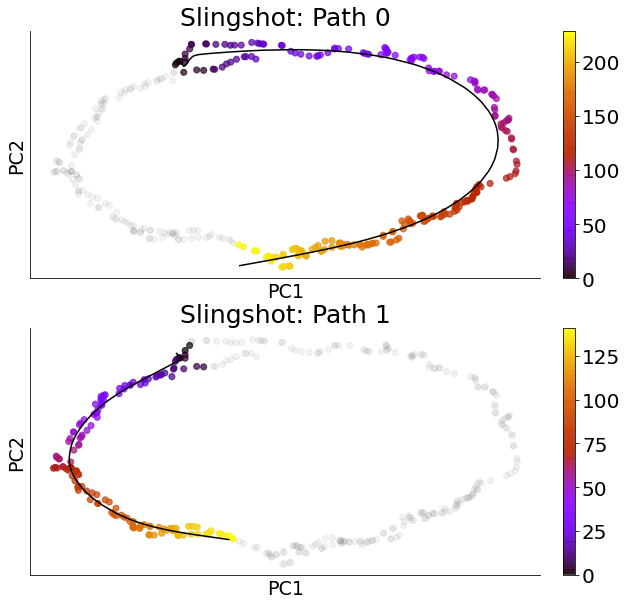

In [16]:
kt_slingshot = visual.slingshot_visual(adata,  results, basis= "pca", figsize=(10,10), save_as = None)# "./sim_results/Symsim/multiple_cycles/200/slingshot_result5.pdf")

In [17]:
kt_slingshot

{&#39;traj_0&#39;: 0.17885119997151508, &#39;traj_1&#39;: -0.5107148266547666}

# velocity DPT

In [ ]:
adata = anndata.read_h5ad("./sim_data/Symsim/multi_cycles_200_rand5.h5ad")
scv.tl.velocity_pseudotime(adata)

In [19]:
y_vdpt = adata.obs['velocity_pseudotime'].values
vdpt_pred  = {}
kt_vdpt = {}
for icol, col in enumerate(pseudo_order.columns):
    non_zeros[col] = np.where(~np.isnan(pseudo_order[col].values.squeeze()))[0]
    vdpt_pred[col] = y_vdpt[non_zeros[col]]
    kt_vdpt[col] = bmk.kendalltau(vdpt_pred[col], pt_true[col])

kt_vdpt

Text(0.5, 1.0, 'velocity diffusion pseudo-time: Path 0')

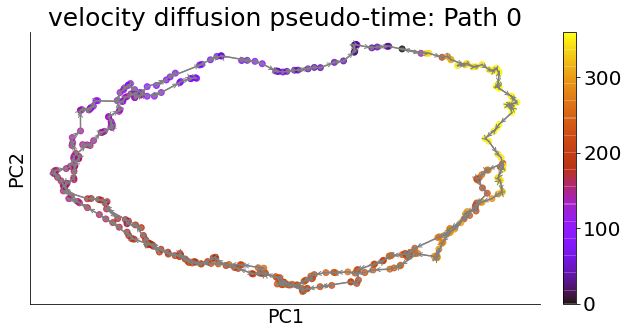

In [37]:
# X_pca = adata.obsm["X_pca"]
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()

for i in range(X_pca.shape[0]-1):
    line = ax.plot(X_pca[i:(i+2), 0], X_pca[i:(i+2), 1], 'gray', '-', alpha = 1)
    visual.add_arrow(line[0], size = 10)

pic = ax.scatter(X_pca[:,0],X_pca[:,1], alpha = 0.7, cmap = 'gnuplot', c = y_vdpt * X_pca.shape[0])
ax.tick_params(axis = "both", direction = "out", labelsize = 16)
ax.set_xlabel("PC1", fontsize = 19)
ax.set_ylabel("PC2", fontsize = 19)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
cbar.ax.tick_params(labelsize = 20)
ax.set_title("velocity diffusion pseudo-time: Path " + str(0), fontsize = 25)

# fig.savefig("./sim_results/Symsim/multiple_cycles/400/vdpt.pdf", bbox_inches = "tight")

## scvelo Latent times

In [22]:
adata = anndata.read_h5ad("./sim_data/Symsim/multi_cycles_200_rand5.h5ad")
scv.tl.recover_dynamics(adata)
# or recover_latent_time, the functionality is the same
scv.tl.latent_time(adata)
lt = adata.obs["latent_time"].values

recovering dynamics
    finished (0:01:16) --&gt; added 
    &#39;fit_pars&#39;, fitted parameters for splicing dynamics (adata.var)
computing terminal states
    identified 1 region of root cells and 1 region of end points 
    finished (0:00:00) --&gt; added
    &#39;root_cells&#39;, root cells of Markov diffusion process (adata.obs)
    &#39;end_points&#39;, end points of Markov diffusion process (adata.obs)
computing latent time
    finished (0:00:00) --&gt; added 
    &#39;latent_time&#39;, shared time (adata.obs)


In [25]:
adata2 = anndata.read_h5ad("./sim_data/Symsim/multi_cycles_200_rand5.h5ad")
scv.tl.recover_dynamics(adata2)
scv.tl.recover_latent_time(adata2)

recovering dynamics
    finished (0:01:15) --&gt; added 
    &#39;fit_pars&#39;, fitted parameters for splicing dynamics (adata.var)
computing terminal states
    identified 1 region of root cells and 1 region of end points 
    finished (0:00:00) --&gt; added
    &#39;root_cells&#39;, root cells of Markov diffusion process (adata.obs)
    &#39;end_points&#39;, end points of Markov diffusion process (adata.obs)
computing latent time
    finished (0:00:00) --&gt; added 
    &#39;latent_time&#39;, shared time (adata.obs)


Text(0.5, 1.0, &#39;velocity diffusion pseudo-time: Path 0&#39;)

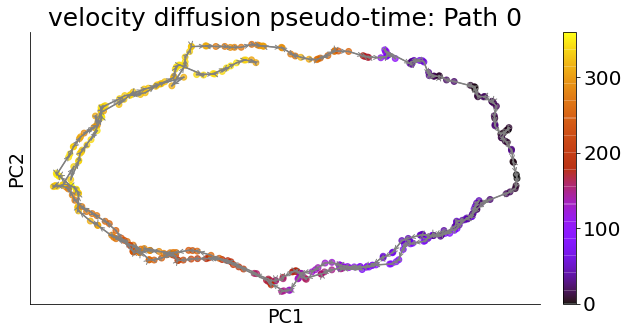

In [23]:
# X_pca = adata.obsm["X_pca"]
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()

for i in range(X_pca.shape[0]-1):
    line = ax.plot(X_pca[i:(i+2), 0], X_pca[i:(i+2), 1], 'gray', '-', alpha = 1)
    visual.add_arrow(line[0], size = 10)

pic = ax.scatter(X_pca[:,0],X_pca[:,1], alpha = 0.7, cmap = 'gnuplot', c = lt * X_pca.shape[0])
ax.tick_params(axis = "both", direction = "out", labelsize = 16)
ax.set_xlabel("PC1", fontsize = 19)
ax.set_ylabel("PC2", fontsize = 19)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
cbar.ax.tick_params(labelsize = 20)
ax.set_title("velocity diffusion pseudo-time: Path " + str(0), fontsize = 25)

# fig.savefig("./sim_results/Symsim/multiple_cycles/400/vdpt.pdf", bbox_inches = "tight")

## Result boxplot

In [70]:
# CellPaths, vdpt, slingshot
kts_array = [[0.9956477214541731, 0.9957000570400597, 0.9954356181934657, -0.25207318678425694, 0.9955192709322193], [-0.24621922334743476, 0.4880428166473475, -0.3215500159416454, 0.4041433452041773, 0.36585252002902147, -0.3558598393558372, -0.3265450243382565, 0.3483877203444393, 0.32903642241733677, -0.45874331365079574], [-0.019459736428839112, -0.1660486658959716, 0.3103455878625159, 0.0008354694806474525]]

In [71]:
import seaborn as sns

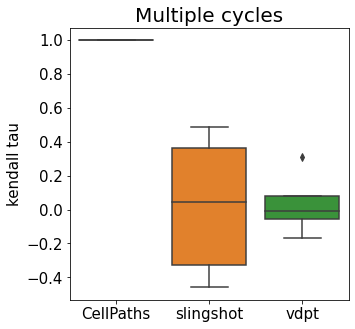

In [73]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
sns.boxplot(data = kts_array, ax = ax)#, x = ["CellPaths", "slingshot", "vdpt"])
ax.set_xticklabels(["CellPaths", "slingshot", "vdpt"],fontsize = 15)
ax.set_ylabel("kendall tau", fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_title("Multiple cycles", fontsize = 20)
fig.savefig("./sim_results/Symsim/multiple_cycles/200/quantity/boxplot.pdf", bbox_inches = "tight")